# 3 Qubit Error Correction Code using Parameterized Quantum Circuit Using Batch Optimization

We implemented a Parameterized Quantum Circuit for 3 Qubits. We added bit-flip noise to the model. Later, we optimized the parameters of the circuit iteratively in order to reduce the error.

Explanation: At the start, 3 Qubits are initialized. q0, q1 and q2
are ancilla bits. A random state is generated as an Input
State. This random state, $|\psi>$ is assigned to the second
qubit, q1. We are adding noise to our circuit in order to
bit flip one qubit. Our aim is retrieving the original input
state even after noise is added to the model by optimizing the parameters iteratively. Therefore,
our target state |$\hat{\psi}$> is equivalent to our input state |$\psi$>.

In [1]:
import numpy as np
import math
np.random.seed(20)

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer
from qiskit.extensions import Initialize

## One Qubit Unitary Circuit

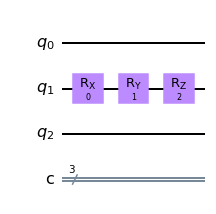

In [2]:
def one_qubit_unitary(params, q1):
    cir = QuantumCircuit(3, 3, name = '1 Qubit Unitaryn')
    
    cir.rx(params[0], q1)
    cir.ry(params[1], q1)
    cir.rz(params[2], q1)
    
    return cir

params = np.arange(0, 3)
one_qubit_unitary(params, 1).draw(output='mpl')

## Two Qubit Rotation Circuit

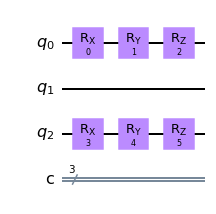

In [3]:
def two_qubit_rotation(params, q1, q2):
    cir = QuantumCircuit(3, 3, name = '2 Qubit Rotation')
    
    cir += one_qubit_unitary(params[0: 3], q1)
    cir += one_qubit_unitary(params[3 : 6], q2)
    
    return cir

params = np.arange(0, 6)
two_qubit_rotation(params, 0, 2).draw(output='mpl')

## Two Qubit Unitary Circuit

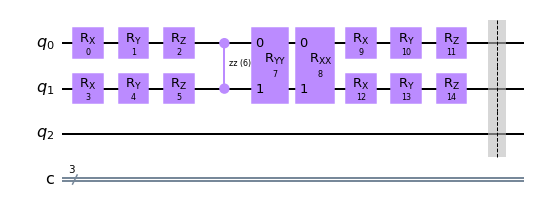

In [4]:
def two_qubit_unitary(params, q1, q2):
    cir = QuantumCircuit(3, 3, name = 'Two Qubit Unitary')
    
    cir += two_qubit_rotation(params[0 : 6], q1, q2)
    cir.rzz(params[6], q1, q2)
    cir.ryy(params[7], q1, q2)
    cir.rxx(params[8], q1, q2)
    cir += two_qubit_rotation(params[9 : 15], q1, q2)
    cir.barrier()
    
    
    return cir

# visualizing Two Qubit Unitary to check
params = np.arange(0, 15)
two_qubit_unitary(params, 0, 1).draw(output='mpl')

# Building Blocks of The Parametric Circuit

## Pooling Circuit

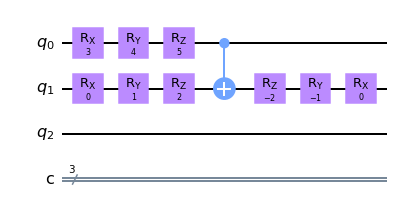

In [5]:
def pooling(params, q1, q2):
    cir = QuantumCircuit(3, 3, name = 'Pooling')
    unitary = one_qubit_unitary(params[0: 3], q2)
    cir += unitary
    cir += one_qubit_unitary(params[3: 6], q1)
    cir.cx(q1, q2)
    cir += unitary.inverse()
    
    return cir

params = np.arange(0, 6)
pooling(params, 0, 1).draw(output='mpl')

## Decoder Circuit

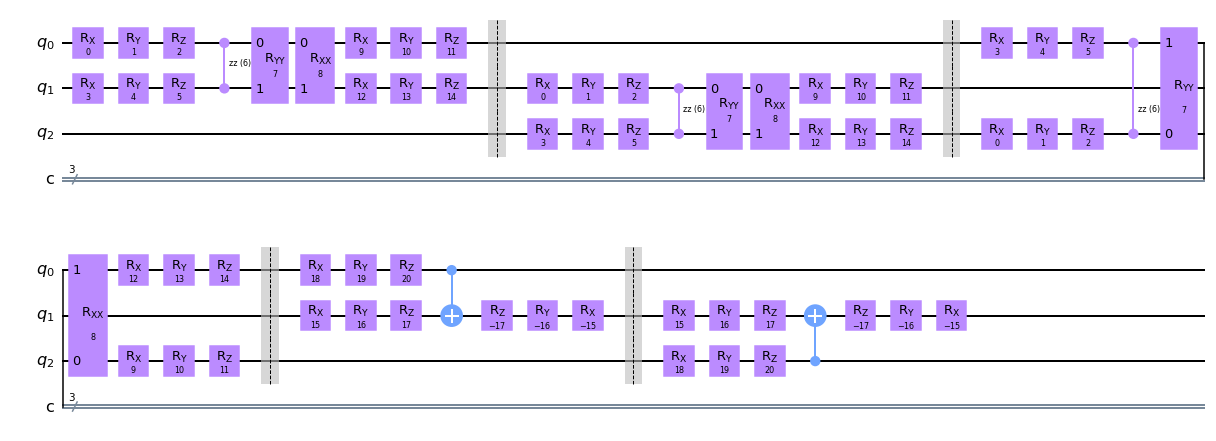

In [6]:
# Defining Decoder circuit. Decoder is inversion of Encoder.
def decoder(params):
    dec = QuantumCircuit(3, 3, name = 'Decoder')
    dec += two_qubit_unitary(params[0 : 15], 0, 1)
    dec += two_qubit_unitary(params[0 : 15], 1, 2)
    dec += two_qubit_unitary(params[0 : 15], 2, 0)
    
    dec += pooling(params[15 : 21], 0, 1)
    dec.barrier()
    dec += pooling(params[15 : 21], 2, 1)
    return dec

# visualizing Decoder to check
params = np.arange(0, 21)
decoder(params).draw(output='mpl')

## Encoder Circuit

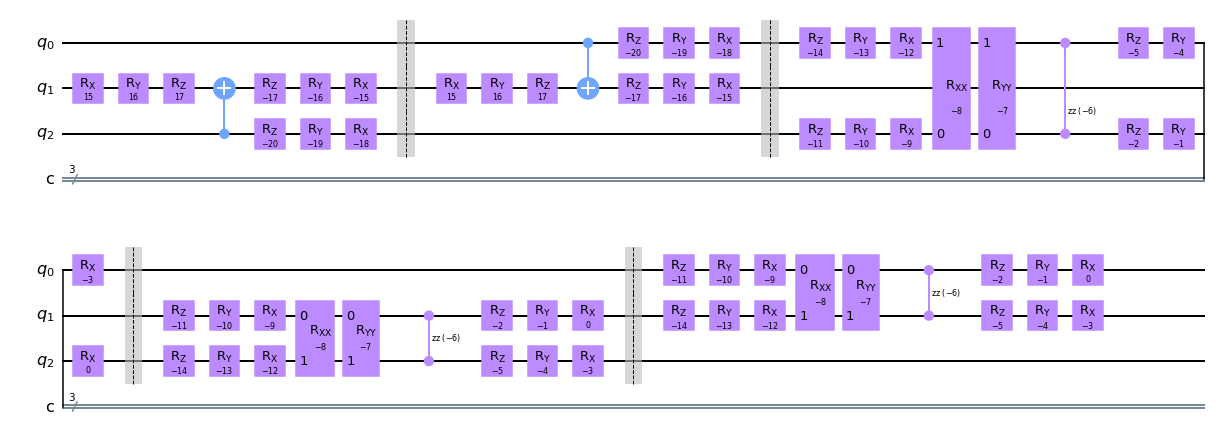

In [7]:
# Defining Encoder circuit. Parameters and input state is given as arguments.
def encoder(decoder):
    enc = QuantumCircuit(3, 3, name = 'Encoder')
    enc = decoder.inverse()
    
    return enc

# visualizing Encoder to check
params = np.arange(0, 21)
encoder(decoder(params)).draw(output='mpl')

## Correction Circuit

In [8]:
# def correction(params):
#     qc = QuantumCircuit(3, 1, name = 'Correction')
#     for i in range(1, 5):
#         qc.u3(params[55+(i-1)*6], params[56+(i-1)*6], params[57+(i-1)*6], 1)
#         qc.u3(params[58+(i-1)*6], params[ 59+(i-1)*6], params[60+(i-1)*6], 2)
        
#         if(i != 4):
#             qc.cx(1,2)
        
#     qc.barrier()
        
#     for i in range(1, 5):
#         qc.u3(params[79+(i-1)*6], params[80+(i-1)*6], params[81+(i-1)*6],0)
#         qc.u3(params[82+(i-1)*6], params[83+(i-1)*6], params[84+(i-1)*6],1)
        
#         if(i != 4):
#             qc.cx(1,0)
#     return qc
# params = np.arange(0,103)
# correction(params).draw(output='mpl', cregbundle = False)

## Complete Circuit

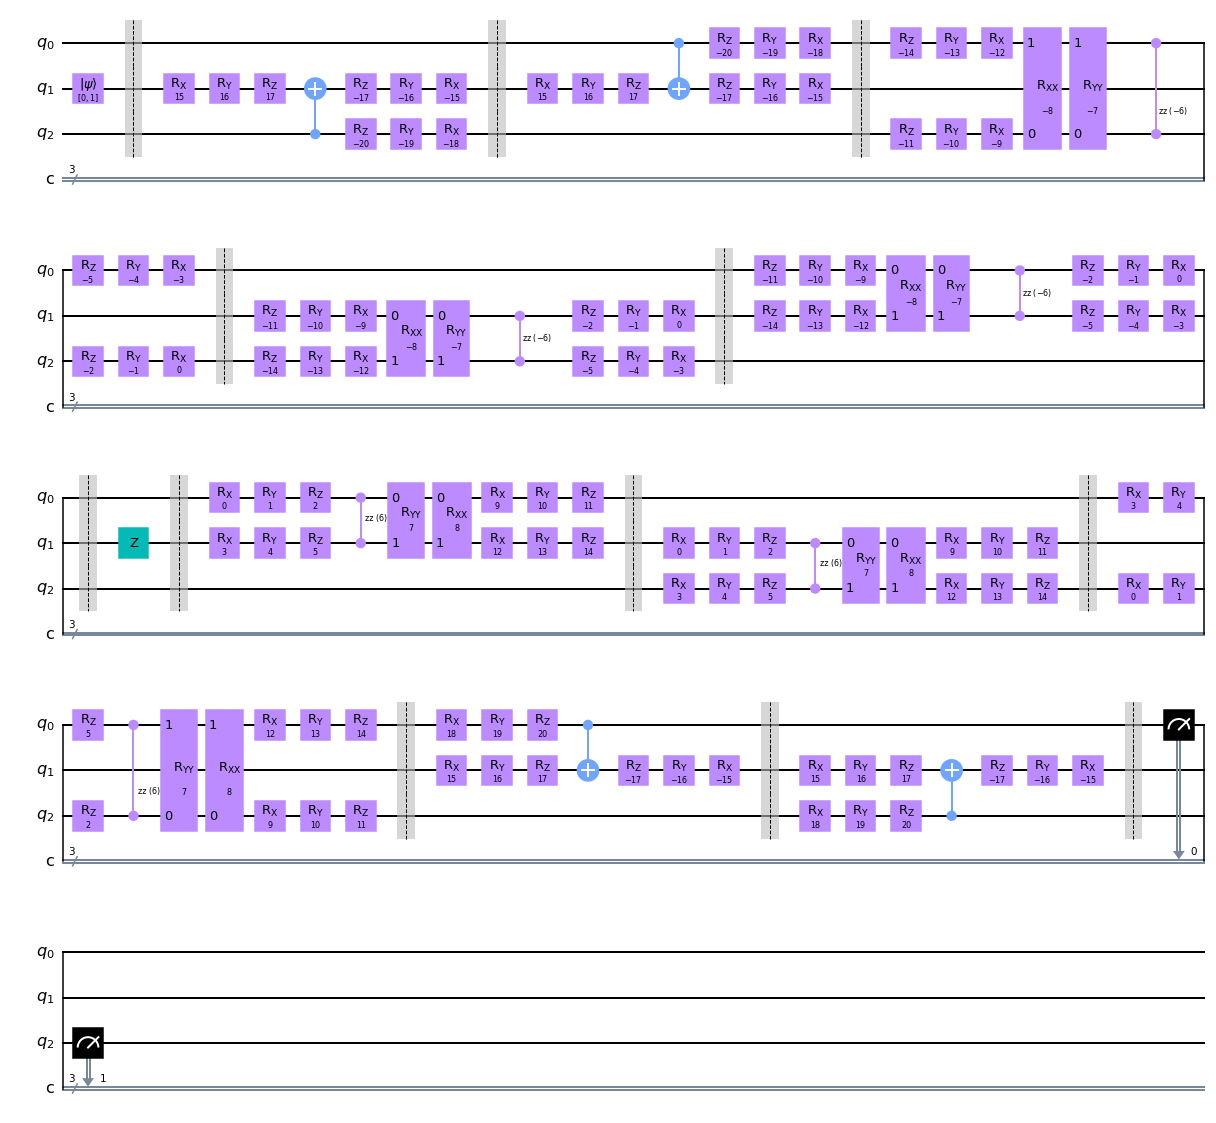

In [9]:
def get_var_form(params, q1_state, error_qubit):
    # Adding input state
    qc = QuantumCircuit(3, 3)
    qc.append(q1_state, [1])
    qc.barrier()

    # Creating encoder circuit
#     enc = encoder(params)
#     # Appending encoder sub-circuit to the main qc. (alternate to qc += enc)
#     qc.append(enc.to_instruction(), enc.qubits)
#     qc.barrier()
    
    dec = decoder(params)
    enc = encoder(dec)
    qc += enc
    
    qc.barrier()
    
    #Adding error to Quantum Circuit
#     error_decision = np.random.choice([0, 1], p=[0, 1])
#     if(error_decision == 1):
#         error_qubit = np.random.randint(3)
    if(error_qubit != -1):
        qc.z(error_qubit)
        qc.barrier()

    # Creating encoder circuit
#     dec = decoder(enc)
#     # Appending decoder sub-circuit to the main qc. (alternate to qc += dec)
#     qc.append(dec.to_instruction(), dec.qubits)

    qc += dec
    
#     corr = correction(params)
#     qc += corr
#     qc.ccx(0, 2, 1)

    
    
    qc.barrier()
    
    # Measuring ancilla qubits
    qc.measure([0, 2], [0, 1])

#     qc.cx(1,0)
#     qc.cx(1,2)
#     qc.barrier()
    
#     if(error_qubit != -1):
#         qc.x(error_qubit)
#         qc.barrier()
        
#     qc.cx(1,0)
#     qc.cx(1,2)
#     qc.ccx(0,2,1)
#     qc.measure([0, 2], [0, 0])   
    
    return qc


# visualizing complete circuit to check
params = np.arange(0, 21)
initial_state = [0, 1]
q1_state = Initialize(initial_state)
get_var_form(params, q1_state, 1).draw(output='mpl')

## Generalized Output State

In [10]:
def gen_states(output_state, target_state):
    alpha = math.sqrt((abs(output_state[0]) ** 2) + (abs(output_state[1]) ** 2) + (abs(output_state[4]) ** 2) + (abs(output_state[5]) ** 2))
    beta = None
    
    if alpha == 0:
        beta = math.sqrt((abs(output_state[2]) ** 2) + (abs(output_state[3]) ** 2) + (abs(output_state[6]) ** 2) + (abs(output_state[7]) ** 2))
    else:
        beta = ( (output_state[2] + output_state[3] + output_state[6] + output_state[7]) / (output_state[0] + output_state[1] + output_state[4] + output_state[5]) ) * alpha
    
    a, b = target_state[0], target_state[1]
    if abs(a) == 0:
        b = abs(b)
    else:
        b = (b / a) * abs(a)
    a = abs(a)
    
    return np.array([alpha, beta]), np.array([a, b])

## Configuring Simulator

In [11]:
# Import Aer
from qiskit import Aer, execute

# Run the quantum circuit on a statevector simulator backend
backend = Aer.get_backend('statevector_simulator')

## Creating Cost Function

In [12]:
def objective_function(params):
    cost = 0
    
    for q1_state in input_states:
        target_state = q1_state
        # initializing state
        q1_state = Initialize(q1_state)
        
        for error_qubit in range(-1, 3):
            # Obtain a quantum circuit instance from the paramters
            qc = get_var_form(params, q1_state, error_qubit)
            # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
            result = execute(qc, backend).result()
            output_state = result.get_statevector(qc)
            output_state = np.array(output_state)
            output_state, target_state = gen_states(output_state, target_state)
            # adding cost for single circuit
            cost += np.linalg.norm(output_state - target_state)
        
    # returning total cost
    return cost

## Running optimizer

In [13]:
from qiskit.aqua.components import optimizers

# for timing the optimization sessions 
import time

In [14]:
# Function to create batch according to batch size
def create_batch(batch_size):
    # Function to return an array after normalizing the elements
    def normalize(arr):
        return arr / np.linalg.norm(arr)
    # Generating random_states
    random_states = np.random.rand(batch_size * 2) + np.random.rand(batch_size * 2)*1j
    # Creating normalized input states from random states and appending to an array
    input_states = np.array([normalize([random_states[i], random_states[i + 1]]) for i in range(0, 2 * batch_size, 2)])
    # Creating target states corresponding to the input states
#     target_states = [[input_states[i][0], 0, input_states[i][1], 0, 0, 0, 0, 0] for i in range (batch_size)]

    return input_states

In [15]:
def optimize_circuit(initial_params, iteration, num_epoch, batch_size):
    current_params = initial_params
    current_error = None
    data = []
    
    # Defining global variables
    global input_states
    global target_states
    global results
    
    input_states = create_batch(batch_size)

    # Initialize the optimizer
    optimizer = optimizers.COBYLA(maxiter = iteration)
    
    # Running batch optimization epoch by epoch
    for i in range (0, num_epoch):
        iter_start = time.time()
        # run optimizer
        ret = optimizer.optimize(num_vars=len(initial_params), 
                                 objective_function=objective_function, initial_point=current_params)
        
        current_params = ret[0]
        current_error = ret[1]
        
        print("Finished Epoch: " + str(i+1) + " ..... " + "Iteration: " + str(iteration) + " ..... " + "Current Error: " + str(current_error) + " ..... " + " Time running: " + str(time.time() - iter_start) + " seconds")
        
        # Simulation result for all circuits will be stored in this list
        data.append(current_error)
    
    # A list to contain each number of epoch
    epoch_list = np.arange(1, (num_epoch + 1))
    # Adding errror and corresponding circuit number to a list
    results = [data, epoch_list]
    
    # returning final optimized parameters and error
    return current_params, current_error

## Initializing Parameters

In [16]:
from math import pi
initial_params = np.random.uniform(0, 2*math.pi, 21)
# initial_params = np.array([math.pi, 0, math.pi, math.pi, 0, math.pi])
print("Initial Parameters:")
print(initial_params)

Initial Parameters:
[3.69533481 5.64050171 5.60165278 5.12605805 0.22550092 4.34644107
 2.37932253 3.25790035 4.13403098 1.21799684 1.71101442 4.51513424
 4.91975677 5.34276613 4.87100733 0.23036863 0.73320836 4.72043585
 1.50305238 1.6009934  5.38862014]


In [ ]:
results = []


# Hyperparameters: number of iteration, number of epochs and batch size
iteration = 200
num_epoch = 50
batch_size = 100

# Optimizing and printing the results
iter_start = time.time()
optimized_params, error = optimize_circuit(initial_params, iteration, num_epoch, batch_size)

print(iteration,"Iterations..... 103 parameters optimized.....", (time.time() - iter_start), "seconds for running")
print()
print("Error:")
print(error)
print()
print("Optimized Parameters:")
print(optimized_params)

# Plot Results for Comparison

In [ ]:
import matplotlib.pyplot as plt
COLOR = '#4a87e0'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# function to plot results for comparison 
def plot_result(results):

    plt.plot(results[1], results[0], label=iteration, marker='o', ls='-')

    plt.xlabel('Epoch Number')
    plt.ylabel('Error')

    plt.title('Evolution of Error with Number of Epochs')

    plt.legend(loc="lower right", bbox_to_anchor=(1.2, 0), title='no. of \n optimizer\n iterations')
    plt.show()

plot_result(results)